# 5. Clustering and Manifold Learning (Niall)

### Importing modules, data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import cycle

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AffinityPropagation

pd.set_option('display.max_columns', None)

#### Scatterplot function
From lab 6

In [2]:
colors = np.array(['orange', 'blue', 'green', 'black', 'pink', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot

def clustering_scatterplot(points, labels, centers, title):
    # plot the examples, i.e. the data points
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

In [3]:
dfCluster = pd.read_json("./russian_ads.json")

In [4]:
dfCluster.head(3)

,language_categories,placement_categories,interests_categories,location_categories,ad_id,ad_copy,ad_landing_page,ad_targeting_location,age_lower,age_upper,age,placements,ad_impressions,ad_clicks,ad_spend_rub,ad_creation_date,month,year,day,ad_end_date,extra_data,pdf_filepath,image_filepath,interest_expansion,excluded_connections,language,ad_spend_usd,efficiency_impressions,efficiency_clicks,conversion_rate,interests_categories_regex,location_categories_regex,date_order_index
0,[Not Specified],[Facebook],[],"[Midwest, Atlantic]",331.0,"""Free Figure's Black Power Rally at VCU:""",https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland: Ferguson, S...",18.0,999.0,18-65+,News Feed on desktop computers or News Feed on...,764.0,43,90.86,06/15/2015,[06],[2015],15,06/16/2015,Completed at the Direction of Ranking Memberof...,2015-06/P10002117.pdf,missing_ad.png,None,None,None,1.66,460.24,25.90,0.06,,Midwest_Atlantic,41
1,[Not Specified],[Facebook],[],"[Midwest, Atlantic]",332.0,A woman pretended Afro-American to gain contro...,https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland; Ferguson, S...",18.0,999.0,18-65+,News Feed on desktop computers or News Feed on...,676.0,47,89.51,06/15/2015,[06],[2015],15,06/16/2015,Completed at the Direction of Ranking Memberof...,2015-06/P10002118.pdf,missing_ad.png,None,None,None,1.63,414.72,28.83,0.07,,Midwest_Atlantic,42
2,[Not Specified],[Facebook],[],"[Midwest, Atlantic]",333.0,2Pac believed in FightTupac Shakur was indeed ...,https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland; Ferguson, S...",18.0,999.0,18-65+,News Feed on desktop computers or News Feed on...,1075.0,47,174.40,06/16/2015,[06],[2015],16,06/17/2015,Completed at the Direction of Ranking Memberof...,2015-06/P10002119.pdf,missing_ad.png,None,None,None,3.21,334.89,14.64,0.04,,Midwest_Atlantic,43


In [5]:
dfCluster['num_interests'] = dfCluster['interests_categories'].str.len()
dfCluster['num_locs'] = dfCluster['location_categories'].str.len()

In [6]:
dfCluster.tail(3)

,language_categories,placement_categories,interests_categories,location_categories,ad_id,ad_copy,ad_landing_page,ad_targeting_location,age_lower,age_upper,age,placements,ad_impressions,ad_clicks,ad_spend_rub,ad_creation_date,month,year,day,ad_end_date,extra_data,pdf_filepath,image_filepath,interest_expansion,excluded_connections,language,ad_spend_usd,efficiency_impressions,efficiency_clicks,conversion_rate,interests_categories_regex,location_categories_regex,date_order_index,num_interests,num_locs
3514,[Not Specified],[Facebook],"[Progressive, Conservative]",[],NaN,Bernie for president!,https://www.facebook.com/Born-Liberal-52262856...,United States,18.0,999.0,18-65+,News Feed on desktop computers or News Feed on...,0.0,0,NaN,07/14/2016,[07],[2016],14,06/08/2016,Completed at the Direction of Ranking Memberof...,2017-07/P10004845.pdf,2017-07/P10004845.-000.png,Liberalism or Libertarianism,None,None,NaN,NaN,NaN,NaN,Progressive_Conservative,,1636,2,0
3515,[English],[Facebook],[Progressive],[],2430.0,"New ideas, old values. Like us!",https://www.facebook.com/bornliberal/,Living In: United States,18.0,999.0,18-65+,News Feed on desktop computers or News Feed on...,49920.0,4799,36629.80,07/14/2016,[07],[2016],14,None,Completed at the Direction of Ranking Memberof...,2017-07/P10004855.pdf,2017-07/P10004855.-000.png,"Bernie Sanders, Social democracy, Liberalismor...",Born Lib,English (UK)or English (US),579.94,86.08,8.27,0.1,Progressive,,1634,1,0
3516,[Not Specified],[Facebook],"[Conservative, Christianity, Anti-Immigrant]",[],1253.0,Secured borders are a national priority. Ameri...,https://www.facebook.com/Secured.Borders/,Living In: United States,18.0,999.0,18-65+,"News Feed on desktop computers, News Feed on m...",2781.0,282,2094.74,08/13/2017,[08],[2017],13,08/15/2017,Completed at the Direction of Ranking Memberof...,2017-08/P10003115.pdf,2017-08/P10003115.-000.png,"Stop Illegal Immigration, Laura Ingraham, FoxN...",None,None,35.03,79.39,8.05,0.1,Conservative_Christianity_Anti-Immigrant,,3516,3,0


### (Data Prep) Converting lists into tuples, numbers

In [7]:
listCols = ['language_categories', 'placement_categories', 'interests_categories', 'location_categories']
dateCols = ['month', 'year']
numCols = ['age_lower', 'age_upper', 'ad_impressions', 'ad_clicks', 'ad_spend_usd', 'month', 'year', 'num_interests', 'num_locs']

for col in listCols:
    dfCluster[col] = dfCluster[col].transform(tuple)

for col in dateCols:
    dfCluster[col] = dfCluster[col].apply(''.join).astype(int)
    
for col in numCols:
    dfCluster[col] = pd.to_numeric(dfCluster[col], errors='coerce')
    
dfCluster.head(1)

,language_categories,placement_categories,interests_categories,location_categories,ad_id,ad_copy,ad_landing_page,ad_targeting_location,age_lower,age_upper,age,placements,ad_impressions,ad_clicks,ad_spend_rub,ad_creation_date,month,year,day,ad_end_date,extra_data,pdf_filepath,image_filepath,interest_expansion,excluded_connections,language,ad_spend_usd,efficiency_impressions,efficiency_clicks,conversion_rate,interests_categories_regex,location_categories_regex,date_order_index,num_interests,num_locs
0,"(Not Specified,)","(Facebook,)",(),"(Midwest, Atlantic)",331.0,"""Free Figure's Black Power Rally at VCU:""",https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland: Ferguson, S...",18.0,999.0,18-65+,News Feed on desktop computers or News Feed on...,764.0,43,90.86,06/15/2015,6,2015,15,06/16/2015,Completed at the Direction of Ranking Memberof...,2015-06/P10002117.pdf,missing_ad.png,None,None,None,1.66,460.24,25.9,0.06,,Midwest_Atlantic,41,0,2


### Making a dataset out of numeric fields

In [8]:
dfNum = dfCluster[['age_lower', 'age_upper', 'ad_impressions', 'ad_clicks', 'ad_spend_usd', 'month', 'year', 'num_interests', 'num_locs']]
#dfNum['ad_id'] = range(1, len(dfNum) + 1)

dfNum = dfNum.dropna()
num_data = np.array(dfNum.values, dtype=float)

cluster_data = np.array(dfNum.values, dtype=float)
print('(number of examples, number of attributes): ', cluster_data.shape)

(number of examples, number of attributes):  (2726, 9)


### Encoding interesting categorical fields into numbers

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

cols = ['interests_categories', 'location_categories']
dfEncoded = df[cols]
for col in cols:
    mlb = MultiLabelBinarizer()
    dfEncoded = dfEncoded.join(pd.DataFrame(mlb.fit_transform(dfEncoded.pop(col)),
                                            columns=mlb.classes_,
                                            index=dfEncoded.index))

dfEncoded['ad_id'] = range(1, len(dfEncoded) + 1)
dfEncoded.head(1)

,Above Age 30,African American,American South,Anti-Immigrant,Army,Below Age 30,Christianity,Conservative,Geographic,Gun Rights,Islam,LGBTQ,Latinx,Memes,Memes and Products,Native American,Patriotism,Police,Prison,Products,Progressive,Self-Defense,Texas,Unknown,Atlantic,Midwest,Non-US,Northeast,Pacific,Southwest,The South,ad_id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1


In [10]:
df = pd.merge(df, dfEncoded, on='ad_id', how='inner').dropna()
# dfNumEncode.drop(['ad_id', 'age_lower', 'age_upper', 'Texas', 'Unknown'], axis=1, inplace=True)
# dfNumEncode.head(1)

### Combining these into a dataframe and array
See conclusion below for why these were eventually omitted

In [11]:
# numEncode_data = np.array(dfNumEncode.values, dtype=float)
# print('(number of examples, number of attributes): ', numEncode_data.shape)

### Scaling the data

In [12]:
min_max_scaler = preprocessing.MinMaxScaler()
num_data = min_max_scaler.fit_transform(num_data)

## K-means Clustering

### Best Value of k?

#### Elbow Method

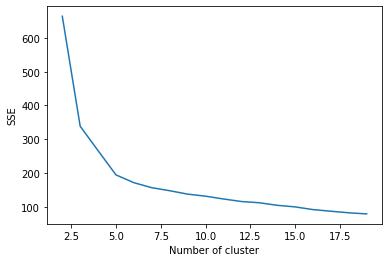

In [13]:
sse = {}
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(num_data)
    #numEncode_data['clusters'] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

#### Silhouette Coefficient Method

In [14]:
for n_cluster in range(2, 20):
    kmeans = KMeans(n_clusters=n_cluster).fit(num_data)
    label = kmeans.labels_
    sil_coeff = silhouette_score(num_data, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.47400357148622124
For n_clusters=3, The Silhouette Coefficient is 0.4970446875626898
For n_clusters=4, The Silhouette Coefficient is 0.4849133192333969
For n_clusters=5, The Silhouette Coefficient is 0.5316596042207945
For n_clusters=6, The Silhouette Coefficient is 0.5094317666254682
For n_clusters=7, The Silhouette Coefficient is 0.5163657287857705
For n_clusters=8, The Silhouette Coefficient is 0.4176312019267323
For n_clusters=9, The Silhouette Coefficient is 0.45382167532442275
For n_clusters=10, The Silhouette Coefficient is 0.3876248852312353
For n_clusters=11, The Silhouette Coefficient is 0.3672725754540254
For n_clusters=12, The Silhouette Coefficient is 0.3985971824817467
For n_clusters=13, The Silhouette Coefficient is 0.351360956393364
For n_clusters=14, The Silhouette Coefficient is 0.3657919310663528
For n_clusters=15, The Silhouette Coefficient is 0.3448004035925407
For n_clusters=16, The Silhouette Coefficient is 0.3653

Initially I ran these tests with all of the data – lists binarized into separate columns for each element. Both of these methods leave an unclear picture re: the optimal value of K.

Our Elbow method produced something not very elbow-looking, and the Silhouette method seemed to be constantly increasing, suggesting that the data is just too varied to produce a small number of clusters. I tested values from 1 to 20 and there just didn't seem to be a good fit.

I experimented with dropping binarized columns (placement categories, interest categories, location categories), and while this did produce better looking k-means graphs, I doubted the usefulness of such clusters. That just left me with [age, impressions, clicks, ad spend, month, year], which wasn't very interesting. 

However, I ultimately realised that the prime motivation behind this propaganda was to sow discord, create confusion, and extremify society as a whole. Trying to find clear patterns in interests/locations is going to be nigh on impossible. Therefore, I settled on focusing on the pure numbers, the columns I mentioned above, as well as adding new columns simply for the number of interests and number of locations targeted. This was to get an idea of how focused the ads were.

With this in mind, both the Elbow and Silhouette methods pointed towards 5 being the optimal value of k.

In [15]:
k = 5
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(num_data)

### Manifold Learning

In [16]:
# append the cluster centers to the dataset
num_data_and_centers = np.r_[num_data, clustered_data_sklearn.cluster_centers_]

####  Apply multi-dimensional scaling (MDS) to project both the data and the k-Means cluster centers to a 2D space¶

In [17]:
# project both th data and the k-Means cluster centers to a 2D space
XYcoordinates = manifold.MDS(n_components=2).fit_transform(num_data_and_centers)
print("transformation complete")

transformation complete


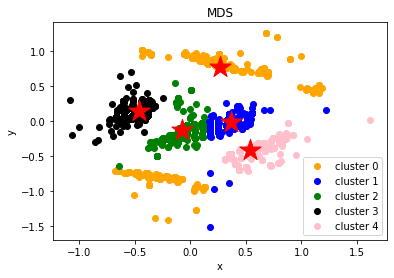

In [18]:
# plot the transformed examples and the centers
# use the cluster assignment to colour the examples
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

#### Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space

In [19]:
# project both th data and the k-Means cluster centers to a 2D space
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(num_data_and_centers)
print("transformation complete")

transformation complete


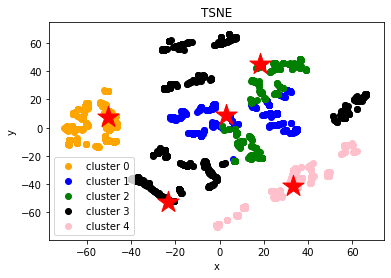

In [20]:
# plot the transformed examples and the centers
# use the cluster assignment to colour the examples
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

### Clutster Analysis

#### Add the cluster labels as an extra column in the original dataframe

In [21]:
dfNum['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=dfNum.index)

In [22]:
dfNum.head()

,age_lower,age_upper,ad_impressions,ad_clicks,ad_spend_usd,month,year,num_interests,num_locs,cluster
0,18.0,999.0,764.0,43,1.66,6,2015,0,2,4
1,18.0,999.0,676.0,47,1.63,6,2015,0,2,4
2,18.0,999.0,1075.0,47,3.21,6,2015,0,2,4
3,18.0,999.0,153.0,10,1.66,6,2015,1,2,4
4,18.0,999.0,476.0,26,1.55,6,2015,0,2,4


In [23]:
dfNum.groupby('cluster').mean()

,age_lower,age_upper,ad_impressions,ad_clicks,ad_spend_usd,month,year,num_interests,num_locs
cluster,,,,,,,,,
0,17.181609,47.344828,11392.937931,655.287356,38.127011,5.291954,2016.002299,1.588506,0.521839
1,17.683267,999.000000,21906.105578,1756.252988,42.624821,10.468127,2016.000000,1.641434,0.161355
2,18.296296,999.000000,10138.747277,784.779956,29.153529,4.352941,2016.000000,1.440087,0.294118
3,17.864776,999.000000,17002.656489,2051.875682,16.035202,3.633588,2017.000000,1.656489,0.085060
4,17.898305,999.000000,10520.656174,780.372881,64.267094,8.353511,2015.000000,1.033898,0.987893


### Conclusions
The plots produced are fairly solid and discrete, considering the nature of the data, with the MDS production probably being the better of the two.

The column for number of locations probably isn't very reliable here, since there are many missing values.

Looking into the data, we can make some rough conclusions about the nature of each cluster:

  0. All age ranges, with a high average spend but low impressions and clicks. These were more targeted ads, with a low average number of interests but a broader range of locations, and were posted earlier in the campaign, ~ August 2015. At this point, the race wasn't too intense and so people weren't "taking the bait" so much. This was important to lay the foundation for the campaign.
  
  
  1. All age ranges, with a low average spend but the highest average clicks and high impressions. They were also the least targeted ads, at around 1.66 interests targeted per ad, but more focused on location. These were posted later, even after the elecction in ~ March 2017, so it makes sense that ads at this point were less expensive, but tensions still high.
  
  
  2. Not targeting older age groups, with mid-range spend. These got low impressions and clicks, despite being posted in ~ May 2016, certainly a high-intensity period. This could be because the ads weren't very focused in terms of interests or locations, or perhaps the younger age groups simply weren't as susceptible to this advertising.
  
  
  3. All age ranges, low average spend and posted just a month before the previous cluster, but slightly more targeted in interests and locations. Impressions and clicks are still low, however, perhaps due to low spend. Unsure.
  
  
  4. All age ranges, high spend, and rewarded with the highest impressions and second-highest clicks. Posted in ~ October 2016 so right around election time, this was a very important period. These are *broad in interests but narrow in location*, similar to the other high-performing cluster 1. We may have found the key here.

## Affinity Propagation
Chosen for its strength in "Many clusters, uneven cluster size, non-flat geometry"

In [24]:
af_clustering = AffinityPropagation(max_iter=300).fit(num_data)

##### Based on https://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html

In [25]:
cluster_centers_indices = af_clustering.cluster_centers_indices_
labels = af_clustering.labels_

n_clusters_ = len(cluster_centers_indices)

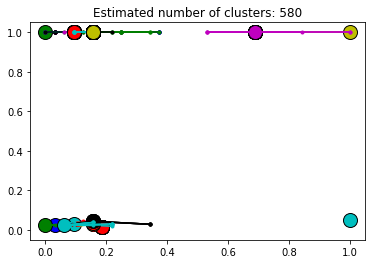

In [26]:
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = num_data[cluster_centers_indices[k]]
    plt.plot(num_data[class_members, 0], num_data[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in num_data[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### What Happened?!
As we can see, this graph is a mess. I was recommended 580 clusters, compared to the 5 from k-means above. I tried multiple different techniques here (Spectral Clustering for clustering, Spectral Embedding and TSNE for manifold learning), but none of them took well.

I think what this shows is that, without enforcing a preset number of clusters, these algorithms simply cannot handle the variance of the dataset. There are two possible conclusions from this.

It's possible that there simply aren't enough samples in the dataset. For such a huge issue, we need more data to understand what's going on.

However, I theorise that even with increased samples, or better labelled ones, we still wouldn't have a clear picture. This demonstrates the effective "randomness" of propaganda. Vladislav Surkov is one of Putin's most senior aides, and known to be the main author of Russia's propaganda network. 

Without going too deep into political theory, his approach has been described as a "dizzying media blitzkrieg of political repression and postmodern propaganda", meaning that it's not as simple as pushing one message, but rather pushing all kinds of messages at the same time, creating such mass confusion that the people simply give up. In this way, they are much easier to mold and accept what you say.

I believe we can see hints of this in my attempts to create clusters from the dataset. It's all over the place, unclear, hard to decipher any clear pattern. I would argue this isn't a fault of mine or the dataset, but rather the explicit strategy being employed.